### TEST RedNet

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import os
import sys
import torch
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset
from tqdm.notebook import trange, tqdm

In [20]:
# Run this cell only if you run this notebook on Google Colab.
from google.colab import drive
drive.mount('/content/drive')

sys.path.append('/content/drive/My Drive/DL_project')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Run this cell only if you do NOT run this notebook on Google Colab.

ROOT_DIR = os.path.dirname(os.getcwd())
sys.path.append(ROOT_DIR)

In [4]:
from src.path import create_dirs
create_dirs()
from src.path import DATA_TRAIN, OUT_DIR, MODELS_DIR, generate_model_filename, generate_log_filename
from models.rednet import RedNet


In [5]:
class ImgDataset(Dataset):
    def __init__(self, data_dir: str) -> None:
        self.data_dir = data_dir
        self.noisy_imgs1 ,self.noisy_imgs2 = torch.load(data_dir)
        self.noisy_imgs1 = self.noisy_imgs1[0:2000, ...]
        self.noisy_imgs2 = self.noisy_imgs2[0:2000, ...]

    def __getitem__(self, index):
        x = self.noisy_imgs1[index, ...]/255.0
        y = self.noisy_imgs2[index, ...]/255.0
        return x, y

    def __len__(self):
        return self.noisy_imgs1.shape[0]

data = ImgDataset(DATA_TRAIN)
trainNumbers = int(len(data)*0.9)
dataNumbers = [trainNumbers, len(data)-trainNumbers]
trainDataset, testDataset = torch.utils.data.random_split(data, 
                                                          dataNumbers)
trainDataLoader=torch.utils.data.DataLoader(trainDataset, batch_size=16,
                                            shuffle=True)
testDataLoader=torch.utils.data.DataLoader(testDataset,batch_size=16,
                                           shuffle=True)

In [6]:
model = RedNet()
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.MSELoss()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)
model.train()
model.to(device)

cpu


RedNet(
  (conv1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (deconv1): Sequential(
    (0): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (deconv2): ConvTranspose2d(128, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (tanh): Tanh()
)

In [7]:
# run this cell to load a pretrained model

name = "model-20220420.pt"
if torch.cuda.is_available():
  model.load_state_dict(torch.load(os.path.join(MODELS_DIR, name)))
else:
  model.load_state_dict(torch.load(os.path.join(MODELS_DIR, name), map_location=torch.device('cpu')))


In [8]:
# run this cell to load pretrained losses

name = "log-20220420.pickle"
with open(os.path.join(MODELS_DIR, name),'rb') as file:
    history = pickle.load(file)
train_loss = history["train_loss"]
test_loss = history["test_loss"]


In [ ]:
# run this cell if you do NOT load pretrained losses
train_loss = []
test_loss = []


In [9]:
epochs=50

with trange(1 + len(train_loss), epochs + 1 + len(train_loss), desc='Training', unit='epoch') as t:

    for epoch in t:
        losses = []

        with tqdm(trainDataLoader, desc=f'Train epoch {epoch}', unit='batch', 
                  leave=False) as t1:
            for x_train ,y_train in t1:
                x_train = x_train.to(device)
                y_train = y_train.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward + backward + optimize
                output = model(x_train)
                loss = criterion(output, y_train)
                loss.backward()
                optimizer.step()
                
                # Append loss
                losses.append(loss)
        
        train_loss.append((sum(losses)/float(len(losses))).item())

        with torch.no_grad():
            losses = []

            with tqdm(testDataLoader, desc=f'Test epoch {epoch}', unit='batch', 
                  leave=False) as t1:
                for x_test, y_test in t1:

                    x_test = x_test.to(device)
                    y_test = y_test.to(device)

                    output = model(x_test)
                    loss = criterion(output, y_test)
                    losses.append(loss)
            
        test_loss.append((sum(losses)/float(len(losses))).item())

# save model
filename = generate_model_filename()
print(filename)
weights = model.state_dict()
torch.save(weights,filename)

# save losses
filename = generate_log_filename()
history = dict()
history["train_loss"] = train_loss
history["test_loss"] = test_loss
with open(filename, 'wb') as f:
  pickle.dump(history, f)


Training:   0%|          | 0/2 [00:00<?, ?epoch/s]

Train epoch 51:   0%|          | 0/113 [00:00<?, ?batch/s]

KeyboardInterrupt: 

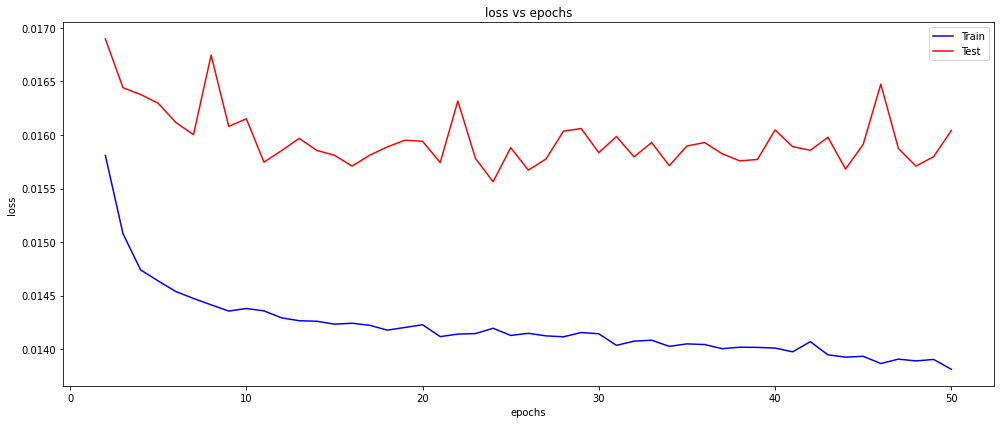

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure(1, figsize=(14, 6))
ax1 = plt.subplot()
ax1.plot(range(2, len(train_loss)+1), train_loss[1:], color="b", label="Train")
ax1.plot(range(2, len(test_loss)+1), test_loss[1:], color="r", label="Test")
ax1.set_title("loss vs epochs")
ax1.set_ylabel("loss")
ax1.set_xlabel("epochs")
fig.tight_layout()
plt.legend()
plt.show()